In [17]:
import requests
import json
def request_tle(year, month, date, hours, norad_id):
    """
    request tle from api server.
    """
    server_url = "https://platformapi.spacemap42.com"
    # SEVERURL = "http://localhost:8082"
    url = f"{server_url}/tles/{year:02d}/{month:02d}/{date:02d}/{hours:02d}?id={norad_id}"
    response = requests.get(url)
    result = json.loads(response.text)
    print(result)
    return result

In [30]:
from datetime import datetime, timedelta

year = 2024
month = 2
date = 23
tles = request_tle(year, month, date, 13, 42984)

{'statusCode': 200, 'message': 'Your request was successfully completed.', 'data': {'targetTleDate': '2024-02-23T13:00:00.000Z', 'foundTleDate': '2024-02-23T00:00:00.000Z', 'tles': [{'name': 'VANGUARD 2', 'firstLine': '1 00011U 59001A   24053.36352452  .00002443  00000-0  12863-2 0  9996', 'secondLine': '2 00011  32.8768  40.8147 1457698 291.6947  53.4878 11.87700742434733'}, {'name': 'VANGUARD 3', 'firstLine': '1 00020U 59007A   24053.43695256  .00001290  00000-0  51012-3 0  9991', 'secondLine': '2 00020  33.3498  64.3343 1654992 210.6798 138.5859 11.58159655386345'}, {'name': 'EXPLORER 7', 'firstLine': '1    22U 59009A   24053.80010104  .00007232  00000-0  45003-3 0  9994', 'secondLine': '2    22  50.2771 243.6677 0116638  20.3992 340.1563 15.05095026426976'}, {'name': 'TIROS 1', 'firstLine': '1 00029U 60002B   24053.45857372  .00001074  00000-0  18364-3 0  9991', 'secondLine': '2 00029  48.3790  76.6319 0023807 232.5780 127.2966 14.76021188417062'}, {'name': 'TRANSIT 2A', 'firstLine

In [31]:
tles

{'statusCode': 200,
 'message': 'Your request was successfully completed.',
 'data': {'targetTleDate': '2024-02-23T13:00:00.000Z',
  'foundTleDate': '2024-02-23T00:00:00.000Z',
  'tles': [{'name': 'VANGUARD 2',
    'firstLine': '1 00011U 59001A   24053.36352452  .00002443  00000-0  12863-2 0  9996',
    'secondLine': '2 00011  32.8768  40.8147 1457698 291.6947  53.4878 11.87700742434733'},
   {'name': 'VANGUARD 3',
    'firstLine': '1 00020U 59007A   24053.43695256  .00001290  00000-0  51012-3 0  9991',
    'secondLine': '2 00020  33.3498  64.3343 1654992 210.6798 138.5859 11.58159655386345'},
   {'name': 'EXPLORER 7',
    'firstLine': '1    22U 59009A   24053.80010104  .00007232  00000-0  45003-3 0  9994',
    'secondLine': '2    22  50.2771 243.6677 0116638  20.3992 340.1563 15.05095026426976'},
   {'name': 'TIROS 1',
    'firstLine': '1 00029U 60002B   24053.45857372  .00001074  00000-0  18364-3 0  9991',
    'secondLine': '2 00029  48.3790  76.6319 0023807 232.5780 127.2966 14.7602

In [8]:
import sgp4
from sgp4.api import Satrec, WGS72
from sgp4.conveniences import jday
from sgp4.ext import invjday

satellite = Satrec.twoline2rv(tles["firstLine"], tles["secondLine"])
jd, fr =jday(year, month, date, hours, 0, 0)
e, position, velocity = satellite.sgp4(jd, fr)
print(position)

(2960.4485934538757, -6679.88772534145, 2313.341903668016)


In [9]:
# Orbit Height (apogee, perigee)
# Orbit Velocity
# Orbit Inclination
# Orbit RAAN
apogees = dict()
perigees = dict()
average_altitudes = dict()
average_velocities = dict()
inclinations = dict()
eccentricities = dict()
RAANs = dict()
epoch = datetime(2023, 11, 22, 0, 0, 0)

while(epoch < datetime.now()):
    print(epoch)
    try:
        year = epoch.year
        month = epoch.month
        date = epoch.day
        # jd, fr =jday(year, month, date, 0, 0, 0)
        tle = request_tle(year, month, date, 0, 58966)
        print(tle)
        satellite = Satrec.twoline2rv(tle["firstLine"], tle["secondLine"])

        jdsatepoch = satellite.jdsatepoch
        jdsatepochfrac = satellite.jdsatepochF
        average_altitude = 0
        average_velocity = 0
        for i in range(1440):
            # jd = jdsatepoch
            fr = jdsatepochfrac + i/1440
            e, position, velocity = satellite.sgp4(jdsatepoch, fr)
            average_altitude += (position[0]**2 + position[1]**2 + position[2]**2)**0.5
            average_velocity += (velocity[0]**2 + velocity[1]**2 + velocity[2]**2)**0.5
        average_altitude /= 1440
        average_velocity /= 1440
        earth_radius = 6378.137
        epochdatetime = invjday(jdsatepoch + jdsatepochfrac)
        apogees[epochdatetime] = satellite.alta * earth_radius
        perigees[epochdatetime] = satellite.altp * earth_radius
        average_altitudes[epochdatetime] = average_altitude - earth_radius
        average_velocities[epochdatetime] = average_velocity
        # velocities.append((velocity[0]**2 + velocity[1]**2 + velocity[2]**2)**0.5)
        rad2deg = 180.0 / 3.141592653589793
        inclinations[epochdatetime] = satellite.inclo*rad2deg
        eccentricities[epochdatetime] = satellite.ecco
        RAANs[epochdatetime] = satellite.nodeo
    except Exception as e:
        print('e', e)
        # apogees.append(None)
        # perigees.append(None)
        # average_altitudes.append(None)
        # average_velocities.append(None)
        # inclinations.append(None)
        # eccentricities.append(None)
        # RAANs.append(None)
        pass
    epoch += timedelta(days=1)
print(apogees)
    

2023-11-22 00:00:00
{'name': 'VANGUARD 2', 'firstLine': '1 00011U 59001A   23324.51699073  .00000365  00000-0  19299-3 0  9998', 'secondLine': '2 00011  32.8688  34.2339 1460440 120.2548 255.0644 11.87387770423570'}
2023-11-23 00:00:00
{'name': 'VANGUARD 2', 'firstLine': '1 00011U 59001A   23324.51699073  .00000365  00000-0  19299-3 0  9998', 'secondLine': '2 00011  32.8688  34.2339 1460440 120.2548 255.0644 11.87387770423570'}
2023-11-24 00:00:00
{'name': 'VANGUARD 2', 'firstLine': '1 00011U 59001A   23324.51699073  .00000365  00000-0  19299-3 0  9998', 'secondLine': '2 00011  32.8688  34.2339 1460440 120.2548 255.0644 11.87387770423570'}
2023-11-25 00:00:00
{'name': 'VANGUARD 2', 'firstLine': '1 00011U 59001A   23324.51699073  .00000365  00000-0  19299-3 0  9998', 'secondLine': '2 00011  32.8688  34.2339 1460440 120.2548 255.0644 11.87387770423570'}
2023-11-26 00:00:00
{'name': 'VANGUARD 2', 'firstLine': '1 00011U 59001A   23324.51699073  .00000365  00000-0  19299-3 0  9998', 'second

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000002C10F7A5660>>
Traceback (most recent call last):
  File "C:\Users\asas4\anaconda3\envs\SPACEMAP\lib\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

In [5]:
apogees

{(2024, 6, 14, 13, 12, 15.578776896267257): 482.9005570319622,
 (2024, 6, 15, 6, 28, 18.84606599834474): 482.82983063947796,
 (2024, 6, 16, 6, 1, 7.29522943523439): 482.88312383700645,
 (2024, 6, 17, 19, 41, 36.60430848625215): 483.18164715664943,
 (2024, 6, 18, 19, 14, 25.079422295360885): 482.66771381383046,
 (2024, 6, 19, 18, 47, 14.194765985279403): 482.90246449061647,
 (2024, 6, 20, 4, 12, 21.741688549785934): 482.79332194601756}

In [6]:
#sort by date
apogees = dict(sorted(apogees.items()))
perigees = dict(sorted(perigees.items()))
average_altitudes = dict(sorted(average_altitudes.items()))
average_velocities = dict(sorted(average_velocities.items()))
inclinations = dict(sorted(inclinations.items()))
eccentricities = dict(sorted(eccentricities.items()))
RAANs = dict(sorted(RAANs.items()))

In [7]:
print(len(apogees.keys()))

7


In [8]:
def draw_graph(data, title, ylabel, color="blue"):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    formatted_dates = [f"{date[0]}-{date[1]}-{date[2]}" for date in data.keys()]
    plt.plot(formatted_dates, data.values(), color=color)
    plt.title(title)
    # plt.ylabel(ylabel, fontsize=12)
    # plt.xlabel("Date", fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks(rotation=30, fontsize=12)

    for i, date in enumerate(formatted_dates):
        if date == "2024-2-19":
            plt.axvline(x=i, color="red", linestyle="--")
        if date == "2024-2-24":
            plt.axvline(x=i, color="red", linestyle="--")
    
    ylim_min = min(data.values()) - (max(data.values()) - min(data.values())) * 0.1
    ylim_max = max(data.values()) + (max(data.values()) - min(data.values())) * 0.1
    plt.ylim(ylim_min, ylim_max)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(30))
    plt.show()

def draw_altitudes(apogees, perigees, average_altitudes):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    formatted_dates = [f"{date[0]}-{date[1]}-{date[2]}" for date in apogees.keys()]
    plt.plot(formatted_dates, apogees.values(), color="blue", label="apogee")
    plt.plot(formatted_dates, perigees.values(), color="red", label="perigee")
    plt.plot(formatted_dates, average_altitudes.values(), color="green", label="average altitude")
    # plt.title("Orbit Height")
    plt.legend()
    plt.yticks(fontsize=12)
    plt.xticks(rotation=30, fontsize=12)
    all_data = list(apogees.values()) + list(perigees.values()) + list(average_altitudes.values())
    ylim_min = min(all_data) - (max(all_data) - min(all_data)) * 0.2
    ylim_max = max(all_data) + (max(all_data) - min(all_data)) * 0.2
    plt.ylim(ylim_min, ylim_max)
    for i, date in enumerate(formatted_dates):
        if date == "2024-2-19":
            plt.axvline(x=i, color="red", linestyle="--")
        if date == "2024-2-24":
            plt.axvline(x=i, color="red", linestyle="--")
    
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(30))
    plt.show()

In [9]:
def print_statistics(data):
    print("min:", min(data.values()))
    print("max:", max(data.values()))
    print("average:", sum(data.values())/len(data.values()))
    print("median:", sorted(data.values())[len(data.values())//2])
    print("standard deviation:", (sum([(value - sum(data.values())/len(data.values()))**2 for value in data.values()])/len(data.values()))**0.5)
    print("variance:", (sum([(value - sum(data.values())/len(data.values()))**2 for value in data.values()])/len(data.values())))
    print("range:", max(data.values()) - min(data.values()))

In [10]:
print("Apogees")
print_statistics(apogees)
print("Perigees")
print_statistics(perigees)
print("Average Altitudes")
print_statistics(average_altitudes)
print("Average Velocities")
print_statistics(average_velocities)
print("Inclinations")
print_statistics(inclinations)
print("Eccentricities")
print_statistics(eccentricities)
print("RAANs")
print_statistics(RAANs)


Apogees
min: 482.66771381383046
max: 483.18164715664943
average: 482.87980841650864
median: 482.88312383700645
standard deviation: 0.1449252162127693
variance: 0.02100331829431793
range: 0.513933342818973
Perigees
min: 480.9164137293975
max: 481.21137381239726
average: 481.10127035207904
median: 481.12577812206973
standard deviation: 0.08542151482110341
variance: 0.0072968351943319895
range: 0.29496008299975074
Average Altitudes
min: 481.3503692459972
max: 481.5864738839391
average: 481.49816240086574
median: 481.50361193210756
standard deviation: 0.06890160746138542
variance: 0.004747431510762843
range: 0.23610463794193493
Average Velocities
min: 7.623077549740737
max: 7.623206369905834
average: 7.623123821153278
median: 7.623120094641578
standard deviation: 3.8103295409410906e-05
variance: 1.451861121056834e-09
range: 0.00012882016509685457
Inclinations
min: 53.1581
max: 53.1607
average: 53.15935714285714
median: 53.1592
standard deviation: 0.0008973885014000475
variance: 8.053061224

In [11]:
def find_max_key(data):
    max_key = None
    max_value = 0
    for key, value in data.items():
        if value > max_value:
            max_key = key
            max_value = value
    return max_key

In [12]:
print(find_max_key(perigees))

(2024, 6, 20, 4, 12, 21.741688549785934)


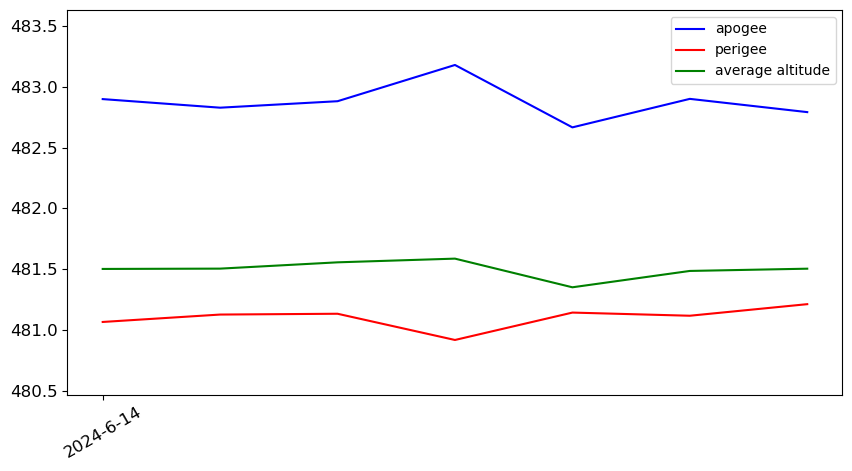

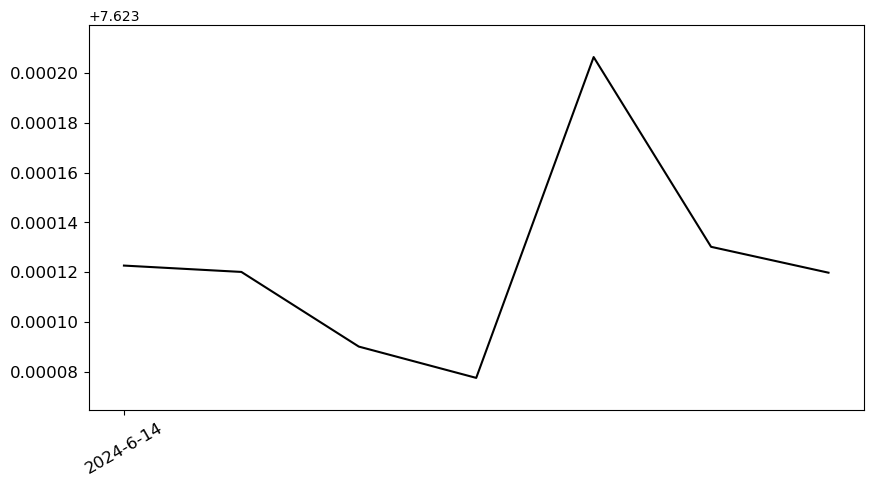

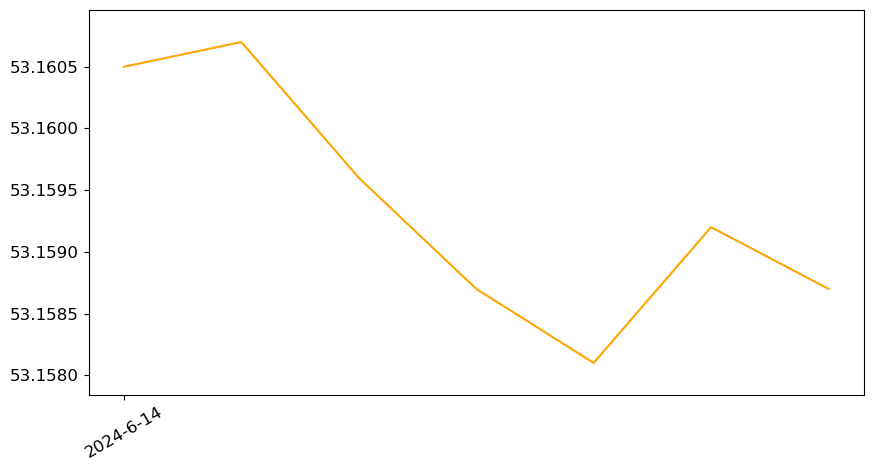

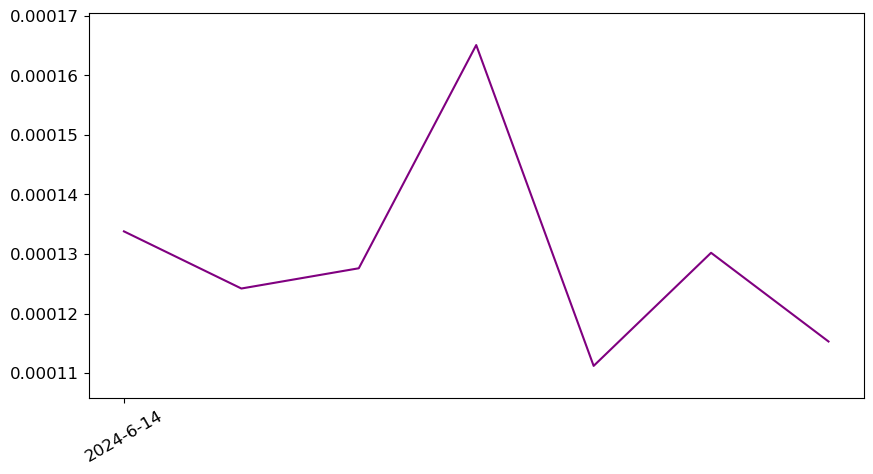

In [13]:
draw_altitudes(apogees, perigees, average_altitudes)
draw_graph(average_velocities,'','', "black")
draw_graph(inclinations, '','', 'orange')
draw_graph(eccentricities, '','','purple')

In [14]:
def draw_graph(x_ticks, data, title, ylabel, color="blue"):
    import matplotlib.pyplot as plt
    #set ratio
    plt.figure(figsize=(10, 5))
    plt.plot(data, color=color)
    plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
    plt.title(title)
    # set y limit
    data_max = max(data)
    data_min = min(data)
    lim_max = data_max + (data_max - data_min) * 0.5
    lim_min = data_min - (data_max - data_min) * 0.5
    plt.ylim(lim_min, lim_max)
    # write y ticks
    # fine_y_ticks = [lim_min + (lim_max - lim_min) * i / 5 for i in range(6)]
    # # y format is 0.0e+00, so convert to 0.0
    # fine_y_ticks = [f"{tick:.2f}" for tick in fine_y_ticks]
    # plt.yticks(fine_y_ticks)
    # coarsen x ticks
    # format x ticks to write only date
    x_ticks = [f"{tick.month:02d}-{tick.day:02d}" for tick in x_ticks]
    plt.xticks(range(len(x_ticks)), x_ticks, rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    # set xticks bold
    
    # x major ticks
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(30))
    plt.ylabel(ylabel)
    # plt.xlabel("Date")
    
    plt.show()
    
    
def draw_altitudes(x_ticks, apogees, perigees, average_altitude, title, ylabel):
    import matplotlib.pyplot as plt
    # plot three lines
    plt.figure(figsize=(10, 5))
    plt.plot(apogees, label="Apogee", color="red")
    plt.plot(perigees, label="Perigee", color="blue")
    plt.plot(average_altitude, label="Average altitude (24h)", color="green")
    plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
    plt.title(title)
    # set y limit
    total_data = apogees + perigees + average_altitude
    data_max = max(total_data)
    data_min = min(total_data)
    lim_max = data_max + (data_max - data_min) * 0.5
    lim_min = data_min - (data_max - data_min) * 0.5
    plt.ylim(lim_min, lim_max)
    # write y ticks
    # fine_y_ticks = [lim_min + (lim_max - lim_min) * i / 5 for i in range(6)]
    # # y format is 0.0e+00, so convert to 0.0
    # fine_y_ticks = [f"{tick:.2f}" for tick in fine_y_ticks]
    # plt.yticks(fine_y_ticks)
    # coarsen x ticks
    # format x ticks to write only date
    x_ticks = [f"{tick.month:02d}-{tick.day:02d}" for tick in x_ticks]
    plt.xticks(range(len(x_ticks)), x_ticks, rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    # x major ticks
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(30))
    plt.ylabel(ylabel)
    plt.legend()
    
    plt.show()
    